## Imports

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt
import utils

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Tokenizer

In [27]:
class Tokenizer:
    def __init__(self, texts, special_tokens=["<pad>"]):
        self.nlp = spacy.load('en_core_web_sm')
        self.special_tokens = special_tokens
        self.vocab = self.build_vocab(texts)
        self.pad_token = "<pad>"
        self.pad_index = self.vocab[self.pad_token]
        self.index_to_token = {idx: token for token, idx in self.vocab.items()}

    def build_vocab(self, texts):
        vocab = {token: idx for idx, token in enumerate(self.special_tokens)}
        idx = len(vocab)
        for text in texts:
            for token in self.tokenize(text):
                if token not in vocab:
                    vocab[token] = idx
                    idx += 1
        return vocab

    def tokenize(self, text):
        return [token.text for token in self.nlp(text)]

    def text_to_sequence(self, text):
        return torch.tensor([self.vocab.get(token, self.pad_index) for token in self.tokenize(text)])

    def pad_sequences(self, sequences):
        return pad_sequence(sequences, batch_first=True, padding_value=self.pad_index)

    def sequence_to_text(self, sequence):
        return ' '.join([self.index_to_token[idx.item()] for idx in sequence if idx.item() in self.index_to_token])


## Load glove embeddings

In [28]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = 'glove.6B.100d.txt'
embeddings_index = load_glove_embeddings(glove_file_path)
print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


## Load data from directories

In [38]:
data_df = utils.load_data_from_directories(articles_dir='./data/news', summaries_dir='./data/summaries')

label_encoder = LabelEncoder()
data_df['category_encoded'] = label_encoder.fit_transform(data_df['category'])

data_df.head()

content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Musicians to tackle US red tape\n\nMusicians' groups are to tackle US visa regulations which are blamed for hindering British acts' chances of succeeding across the Atlantic.\n\nA singer hoping to perform in the US can expect to pay $1,300 (£680) simply for obtaining a visa. Groups including the Musicians' Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.\n\nNigel McCune from the Musicians' Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.\n\n"The US is the world's biggest music market, which means something has to be done about the creaky bureaucracy," says Mr McCune. "The current situation is preventing British acts from maintaining momentum and developing in the US," he added.\n\nThe Musicians' Union stance is being endorsed by the Music Managers' Forum (MMF), who say British artists face "an uphill struggle" to succeed in the US, thanks to the tough visa requirements, which are also seen as impractical. The MMF's general secretary James Seller said: "

## Processing data

In [30]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

tokenizer = Tokenizer(train_df['content'])

In [31]:
train_sequences = [tokenizer.text_to_sequence(text) for text in train_df['content']]
test_sequences = [tokenizer.text_to_sequence(text) for text in test_df['content']]

train_X = tokenizer.pad_sequences(train_sequences)
test_X = tokenizer.pad_sequences(test_sequences)

train_X

tensor([[   1,    2,    3,  ...,    0,    0,    0],
        [ 125,   23,  126,  ...,    0,    0,    0],
        [ 236,  237,  238,  ...,    0,    0,    0],
        ...,
        [   1,  500,  284,  ...,    0,    0,    0],
        [ 546,  923, 3051,  ...,    0,    0,    0],
        [ 173,  229, 1272,  ...,    0,    0,    0]])

In [32]:
train_Y = torch.tensor(train_df['category_encoded'].values)
test_Y = torch.tensor(test_df['category_encoded'].values)

train_Y

tensor([4, 4, 4,  ..., 0, 2, 0])

In [33]:
x1 = tokenizer.sequence_to_text(train_X[0])
x1

'The laser links also take far less time to set up and get working , said Mr Sridharan . In 12 months the lasers have helped the firm set up networks in more than 700 locations . The laser bridges can route data at speeds up to 1.25gbps ( 2,000 times faster than a 512kbps broadband connection ) but Tata is running its hardware at more modest speeds of 1 - 2mbps . Tata Teleservices is using the lasers to make the link between customers \' offices and its own core network . The Lightpointe laser bridges work over distances of up to 4 km and are being used to route both voice and data from businesses on to the backbone of the network . An Indian telecommunications firm has turned to lasers to help it overcome the problems of setting up voice and data networks in the country . The laser bridges work across distances up to 4 km and can be set up much faster than cable connections . "In this particular geography getting permission to dig the ground and lay the pipes is a bit of a task , " sa

In [34]:
y1 = label_encoder.inverse_transform([train_Y[0].item()])
y1

array(['tech'], dtype=object)

## CNN Classifier

In [41]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, embeddings=None):
        super(CNNClassifier, self).__init__()
        if embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax here, nn.CrossEntropyLoss handles multiple classes
        return x

## Train and Evaluate functions

In [56]:
def train_model(model, train_X, train_Y, num_epochs=10, learning_rate=0.001, save_path='saved_models/cnn_model.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_predictions = 0
        with tqdm(total=len(train_X), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for i in range(len(train_X)):
                optimizer.zero_grad()
                outputs = model(train_X[i].unsqueeze(0))
                loss = criterion(outputs, train_Y[i].unsqueeze(0))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == train_Y[i]).sum().item()

                accuracy = correct_predictions / (i + 1)
                pbar.set_postfix(loss=epoch_loss/(i+1), accuracy=accuracy)
                pbar.update(1)

        train_losses.append(epoch_loss / len(train_X))
        train_accuracies.append(accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_X):.4f}, Accuracy: {accuracy:.4f}')

    # Save the model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    return train_losses, train_accuracies

def evaluate_model(model, test_X, test_Y):
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == test_Y).sum().item() / len(test_Y)
        print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10: 100%|██████████| 3560/3560 [00:58<00:00, 60.78batch/s, accuracy=0.767, loss=0.632]


Epoch [1/10], Loss: 0.6324, Accuracy: 0.7671


Epoch 2/10: 100%|██████████| 3560/3560 [00:58<00:00, 61.22batch/s, accuracy=0.952, loss=0.166]


Epoch [2/10], Loss: 0.1657, Accuracy: 0.9520


Epoch 3/10: 100%|██████████| 3560/3560 [00:58<00:00, 60.48batch/s, accuracy=0.976, loss=0.102] 


Epoch [3/10], Loss: 0.1023, Accuracy: 0.9756


Epoch 4/10: 100%|██████████| 3560/3560 [00:57<00:00, 61.63batch/s, accuracy=0.984, loss=0.0837]


Epoch [4/10], Loss: 0.0837, Accuracy: 0.9840


Epoch 5/10: 100%|██████████| 3560/3560 [00:58<00:00, 60.81batch/s, accuracy=0.989, loss=0.059] 


Epoch [5/10], Loss: 0.0590, Accuracy: 0.9893


Epoch 6/10: 100%|██████████| 3560/3560 [00:55<00:00, 64.60batch/s, accuracy=0.988, loss=0.0565]


Epoch [6/10], Loss: 0.0565, Accuracy: 0.9885


Epoch 7/10: 100%|██████████| 3560/3560 [00:58<00:00, 60.40batch/s, accuracy=0.994, loss=0.0314]


Epoch [7/10], Loss: 0.0314, Accuracy: 0.9944


Epoch 8/10: 100%|██████████| 3560/3560 [01:01<00:00, 57.63batch/s, accuracy=0.992, loss=0.109] 


Epoch [8/10], Loss: 0.1093, Accuracy: 0.9924


Epoch 9/10: 100%|██████████| 3560/3560 [00:51<00:00, 68.79batch/s, accuracy=0.995, loss=0.0202]


Epoch [9/10], Loss: 0.0202, Accuracy: 0.9947


Epoch 10/10: 100%|██████████| 3560/3560 [00:53<00:00, 66.81batch/s, accuracy=0.996, loss=0.0483]


Epoch [10/10], Loss: 0.0483, Accuracy: 0.9955
Model saved to saved_models/cnn_model.pth


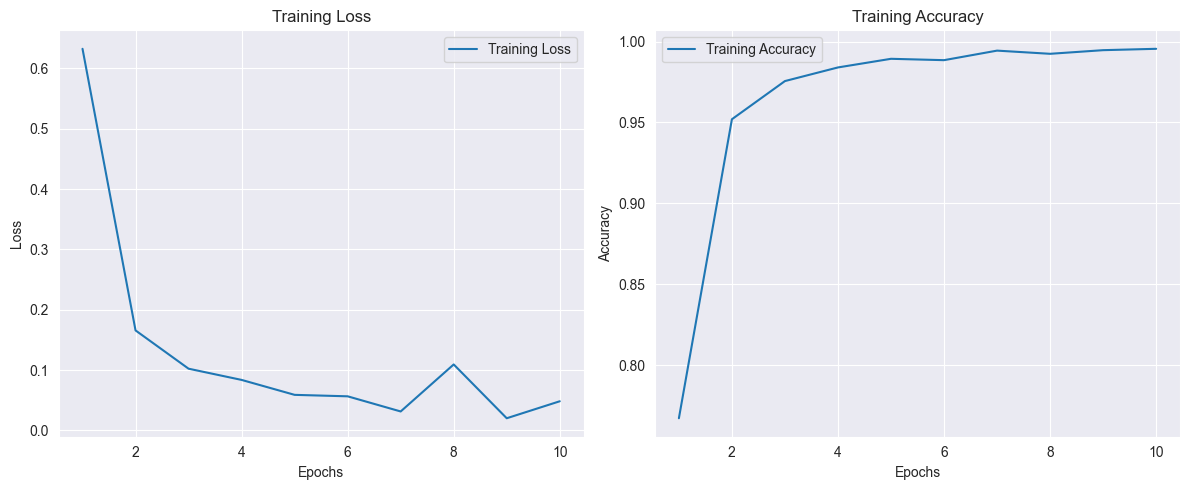

Accuracy: 96.52%


In [57]:
vocab_size = len(tokenizer.vocab)
embedding_dim = 100  # Assuming GloVe embeddings of 100 dimensions
num_classes = len(label_encoder.classes_)

embeddings_array = np.array([embeddings_index.get(token, np.random.normal(scale=0.6, size=(embedding_dim,))) for token in tokenizer.vocab.keys()])
embeddings = torch.tensor(embeddings_array, dtype=torch.float32)

model = CNNClassifier(vocab_size, embedding_dim, num_classes, embeddings=embeddings)

# Train the model
train_losses, train_accuracies = train_model(model, train_X, train_Y, num_epochs=10, learning_rate=0.001, save_path='saved_models/cnn_model.pth')

# Plot the training loss and accuracy
epochs = range(1, 11)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
evaluate_model(model, test_X, test_Y)